In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import os, cv2

In [2]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input, Flatten

In [3]:
sdir=r'E:\Corneal_Ulcer\2.0'
aug_dir=os.path.join(sdir,'augmented_grade')
datasets = [aug_dir]
output = []
class_names = ['grade 0', 'grade 1','grade 2', 'grade 3', 'grade 4']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

for dataset in datasets:
   images = []
   labels = []

        # Iterate through each folder corresponding to a category
   for folder in os.listdir(dataset):
    label = class_names_label[folder]
               # Iterate through each image in our folder
    for file in os.listdir(aug_dir+"/"+folder):
               # Get the path name of the image
      # print(file)
       img_path = os.path.join(os.path.join(dataset, folder), file)

       image = cv2.imread(img_path)
       #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
       image = cv2.resize(image, (128,128))
       images.append(image)
       labels.append(label)
   imagess = np.array(images, dtype = 'float32')
   labelss = np.array(labels, dtype = 'int32')

   train_images=imagess
   train_labels=labelss

In [4]:
from sklearn.model_selection import train_test_split
gpu_device = tf.config.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu_device, True)

with tf.device('/GPU:0'):
    X_train, X_test,Y_train,Y_test= train_test_split(train_images,train_labels,test_size=0.25, shuffle= True, random_state=42)
    

In [5]:
# Load the inception_v3 model
inceptionV3 = InceptionV3(weights='imagenet', include_top=False)

# Add a global spatial average pooling layer
x = inceptionV3.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = Flatten()(x)
x = Dense(128, activation='relu')(x)

# Add a logistic layer for 5 classes (assuming the labels are from 0 to 4)
predictions = Dense(5, activation='softmax')(x)

In [6]:
# Define the model
model = Model(inputs=inceptionV3.input, outputs=predictions)

# Freeze the layers of the base model
for layer in inceptionV3.layers:
    layer.trainable = False

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [8]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Train the model
history = model.fit(X_train, Y_train, epochs=100, validation_split=0.25,batch_size=128)

Epoch 1/100
53/53 [==============================] - 10s 95ms/step - loss: 14.4623 - accuracy: 0.2701 - val_loss: 4.0213 - val_accuracy: 0.2996
Epoch 2/100
53/53 [==============================] - 4s 67ms/step - loss: 3.1777 - accuracy: 0.3323 - val_loss: 2.6497 - val_accuracy: 0.3511
Epoch 3/100
53/53 [==============================] - 3s 66ms/step - loss: 2.5854 - accuracy: 0.3567 - val_loss: 2.4574 - val_accuracy: 0.3351
Epoch 4/100
53/53 [==============================] - 4s 67ms/step - loss: 2.0960 - accuracy: 0.3766 - val_loss: 1.9671 - val_accuracy: 0.3818
Epoch 5/100
53/53 [==============================] - 4s 67ms/step - loss: 1.8250 - accuracy: 0.3883 - val_loss: 1.7307 - val_accuracy: 0.3942
Epoch 6/100
53/53 [==============================] - 4s 69ms/step - loss: 1.5854 - accuracy: 0.4089 - val_loss: 1.7627 - val_accuracy: 0.3702
Epoch 7/100
53/53 [==============================] - 4s 69ms/step - loss: 1.5166 - accuracy: 0.4273 - val_loss: 1.7841 - val_accuracy: 0.3742
Epoc

In [10]:
# Evaluate the model
score = model.evaluate(X_test, Y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

94/94 [==============================] - 2s 23ms/step - loss: 2.1532 - accuracy: 0.4843
Test loss: 2.153221607208252
Test accuracy: 0.484333336353302


In [12]:
# Evaluate the model
score1 = model.evaluate(X_train, Y_train)
print('Train loss:', score1[0])
print('Train accuracy:', score1[1])

282/282 [==============================] - 7s 25ms/step - loss: 0.8548 - accuracy: 0.7519
Train loss: 0.8548414707183838
Train accuracy: 0.7518888711929321


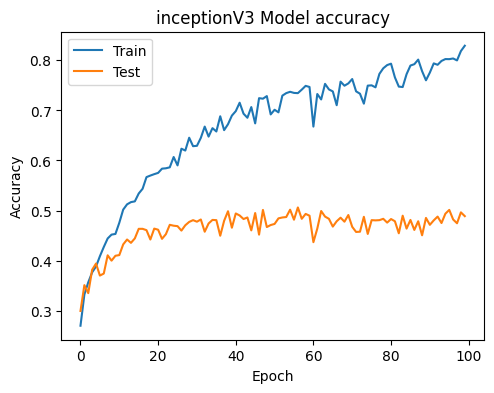

In [16]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('inceptionV3 Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

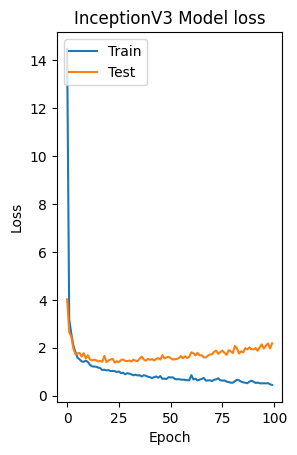

In [17]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('InceptionV3 Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score
# After training the model, make predictions on the test set
Y_pred = model.predict(X_test)

# Convert predicted probabilities to class labels
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Calculate precision, recall, and F1 score
precision = precision_score(Y_test, Y_pred_classes, average='weighted')
recall = recall_score(Y_test, Y_pred_classes, average='weighted')
f1 = f1_score(Y_test, Y_pred_classes, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


94/94 [==============================] - 3s 23ms/step
Precision: 0.4897
Recall: 0.4843
F1 Score: 0.4822
